# 🧪 CIFAR-100 Image Classification

Train and evaluate Convolutional Neural Networks (CNNs) and optional transfer learning models on the CIFAR-100 dataset.  
This notebook is structured for clarity, reproducibility, and GitHub-readiness.


## 📦 Imports

In [1]:
# ============================================================
# 📦 Imports
# ============================================================
import os, random, sys, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics, regularizers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical


In [2]:
# ============================================================
# 🔄 Reproducibility
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# ============================================================
# ⚙️ Training Configuration
# ============================================================
CONFIG = {
    "model_type": "cnn",   # "cnn" | "resnet50" | "efficientnetv2b0"
    "freeze_epochs": 3,
    "finetune_epochs": 20,
    "batch_size": 128,
    "epochs": 30,          # used for CNN only
    "learning_rate": 1e-3,
    "l2": 1e-4,
    "apply_l2_to_convs": False,
    "optimizer": "adamw",  # "adam" | "adamw" | "sgd"
    "weight_decay": 1e-4,
    "momentum": 0.9,
    "dropout": 0.4,
    "input_shape": (32, 32, 3),
    "num_classes": 100,
}

## 📥 Load & Preprocess CIFAR-100

In [4]:
# ============================================================
# 📥 Load & Preprocess CIFAR-100
# ============================================================
def get_data(one_hot=True):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
    x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0
    if one_hot:
        y_train, y_test = to_categorical(y_train, 100), to_categorical(y_test, 100)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = get_data(one_hot=True)
print("Train:", x_train.shape, y_train.shape, " Test:", x_test.shape, y_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train: (50000, 32, 32, 3) (50000, 100)  Test: (10000, 32, 32, 3) (10000, 100)


## 🎭 CIFAR-100 Class Labels
Useful for mapping predictions to human-readable names.


In [5]:
CIFAR100_LABELS = [
    'apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',
    'bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle',
    'chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur',
    'dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard',
    'lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain',
    'mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree',
    'plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket',
    'rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider',
    'squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor',
    'train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm'
]

## 🌀 (Optional) Data Augmentation

In [6]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

## 🧠 Build the CNN Model

In [7]:
def build_model(num_classes=100, input_shape=(32, 32, 3), cfg=CONFIG):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(cfg["l2"]))(x)
    x = layers.Dropout(cfg["dropout"])(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="cifar100_cnn")
    return model

## ⚡ Compile Model


In [8]:
model = build_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy(name="acc"),
             metrics.TopKCategoricalAccuracy(k=5, name="top5")]
)
model.summary()

Model: "cifar100_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,252 (3.19 MB)

 Trainable params: 837,252 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

## ⏱️ Callbacks

In [9]:
ckpt_path = "best_cifar100_cnn.keras"
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
]

## 🏋️ Train

In [10]:
history = model.fit(
    x_train, y_train,
    batch_size=CONFIG["batch_size"],
    epochs=CONFIG["epochs"],
    validation_split=0.1,
    callbacks=cbs,
    verbose=2
)

Epoch 1/30

Epoch 1: val_acc improved from -inf to 0.07100, saving model to best_cifar100_cnn.keras
352/352 - 11s - 30ms/step - acc: 0.0288 - loss: 4.4010 - top5: 0.1222 - val_acc: 0.0710 - val_loss: 4.1342 - val_top5: 0.2326 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_acc improved from 0.07100 to 0.14340, saving model to best_cifar100_cnn.keras
352/352 - 3s - 8ms/step - acc: 0.0950 - loss: 3.9086 - top5: 0.2934 - val_acc: 0.1434 - val_loss: 3.6337 - val_top5: 0.3828 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_acc improved from 0.14340 to 0.18880, saving model to best_cifar100_cnn.keras
352/352 - 3s - 8ms/step - acc: 0.1416 - loss: 3.6322 - top5: 0.3869 - val_acc: 0.1888 - val_loss: 3.4524 - val_top5: 0.4344 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_acc improved from 0.18880 to 0.22080, saving model to best_cifar100_cnn.keras
352/352 - 3s - 9ms/step - acc: 0.1778 - loss: 3.4428 - top5: 0.4473 - val_acc: 0.2208 - val_loss: 3.2641 - val_top5: 0.4890 - learnin

## 📈 Learning Curves

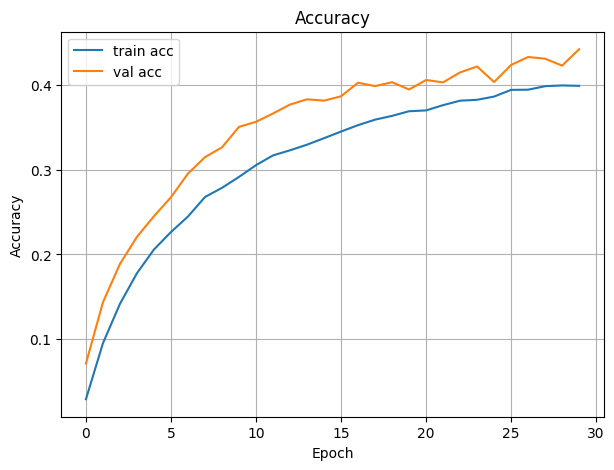

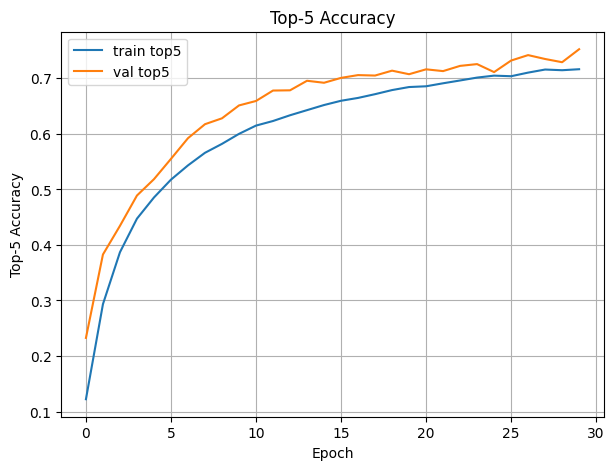

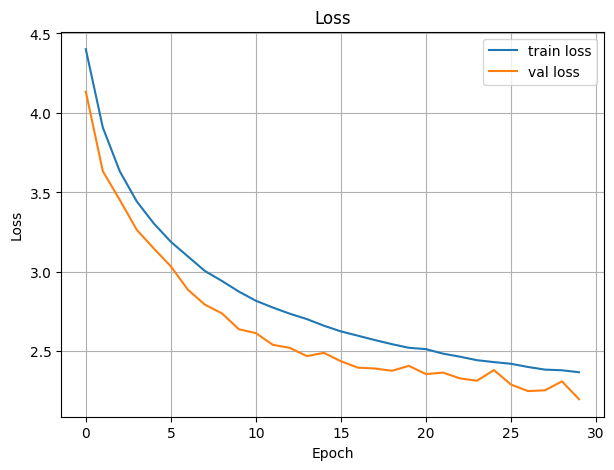

In [11]:
def plot_history(hist):
    plt.figure(figsize=(7,5))
    plt.plot(hist.history["acc"], label="train acc")
    plt.plot(hist.history["val_acc"], label="val acc")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(hist.history["top5"], label="train top5")
    plt.plot(hist.history["val_top5"], label="val top5")
    plt.title("Top-5 Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Top-5 Accuracy")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(hist.history["loss"], label="train loss")
    plt.plot(hist.history["val_loss"], label="val loss")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.show()

plot_history(history)

## ✅ Evaluate on Test Set

In [12]:
test_metrics = model.evaluate(x_test, y_test, verbose=0, return_dict=True)
print(json.dumps(test_metrics, indent=2))

{
  "acc": 0.453000009059906,
  "loss": 2.1510493755340576,
  "top5": 0.757099986076355
}


## 🎯 Per-Class Accuracy
Let's see which classes perform well and which don't.



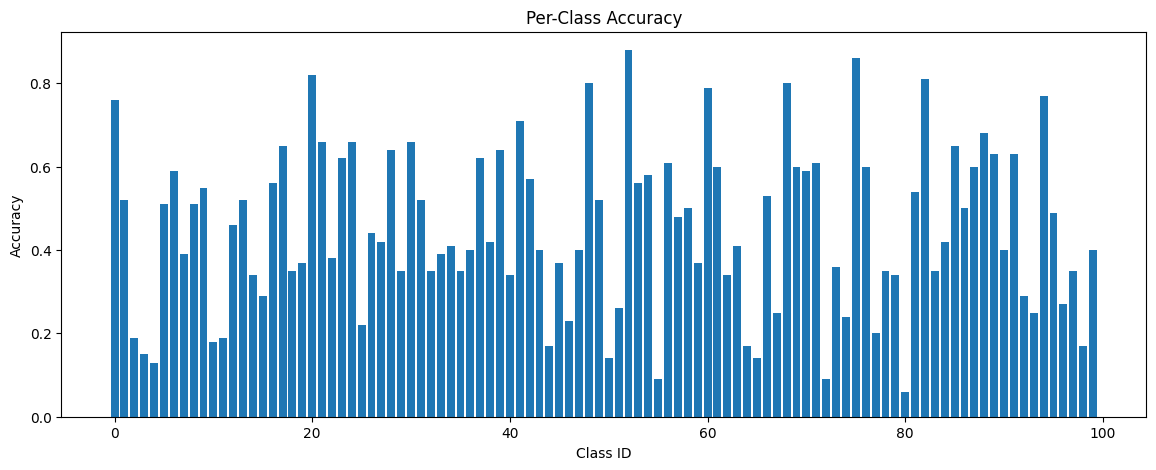

In [13]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(x_test, batch_size=256, verbose=0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

acc_per_class = []
for i in range(100):
    idx = (y_test_labels == i)
    acc = accuracy_score(y_test_labels[idx], y_pred_labels[idx])
    acc_per_class.append(acc)

plt.figure(figsize=(14,5))
plt.bar(range(100), acc_per_class)
plt.title("Per-Class Accuracy")
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.show()

## 🧾 Confusion Matrix & Classification Report

In [14]:
print(classification_report(y_test_labels, y_pred_labels, digits=3))


              precision    recall  f1-score   support

           0      0.691     0.760     0.724       100
           1      0.598     0.520     0.556       100
           2      0.339     0.190     0.244       100
           3      0.429     0.150     0.222       100
           4      0.210     0.130     0.160       100
           5      0.425     0.510     0.464       100
           6      0.434     0.590     0.500       100
           7      0.696     0.390     0.500       100
           8      0.451     0.510     0.479       100
           9      0.640     0.550     0.591       100
          10      0.600     0.180     0.277       100
          11      0.275     0.190     0.225       100
          12      0.582     0.460     0.514       100
          13      0.397     0.520     0.450       100
          14      0.400     0.340     0.368       100
          15      0.433     0.290     0.347       100
          16      0.418     0.560     0.479       100
          17      0.644    

## 🔍 Example Predictions


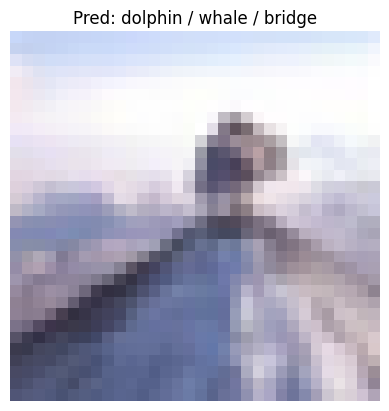

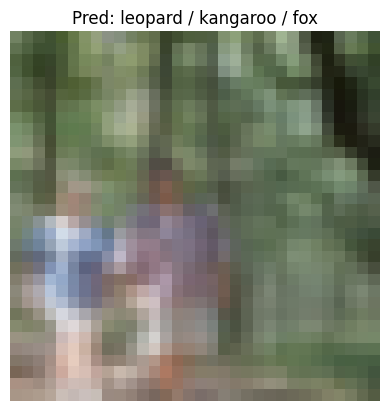

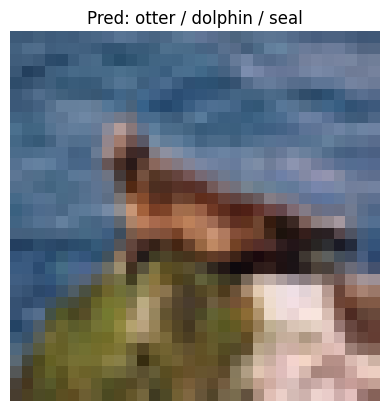

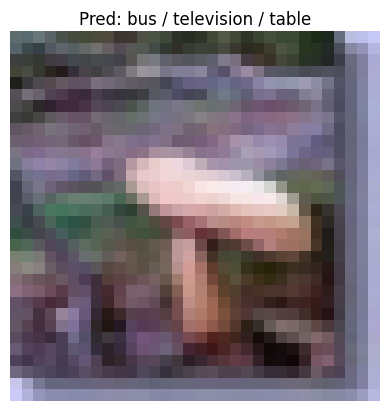

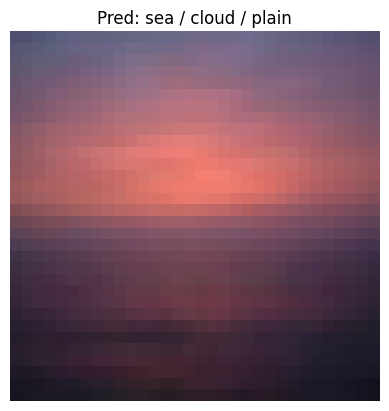

In [15]:
def predict_images(model, images, k=5):
    probs = model.predict(images, verbose=0)
    topk_idx = np.argsort(-probs, axis=1)[:, :k]
    topk_prob = np.take_along_axis(probs, topk_idx, axis=1)
    topk_labels = [[CIFAR100_LABELS[i] for i in row] for row in topk_idx]
    return topk_labels, topk_prob

labels, probs = predict_images(model, x_test[:5])

for i in range(5):
    plt.imshow(x_test[i])
    plt.axis("off")
    plt.title(f"Pred: {labels[i][0]} / {labels[i][1]} / {labels[i][2]}")
    plt.show()

## 💾 Save Model

In [16]:
model.save("final_cifar100_cnn.keras")
print("✅ Model saved: final_cifar100_cnn.keras")

✅ Model saved: final_cifar100_cnn.keras


# 🚀 Advanced: Transfer Learning, Regularization, Optimizers, and Tuning

This section adds:
- **Pretrained backbones** (EfficientNetV2B0, ResNet50) for transfer learning
- **L2 regularization** on the classifier (and optionally conv blocks)
- **AdamW / SGD+Momentum** optimizers
- **(Optional)** Hyperparameter tuning via **Keras Tuner** or **Optuna**

In [47]:
CONFIG.update({
    "model_type": "efficientnetv2b0",   # or "resnet50"
    "backbone_input": (224, 224),       # <-- NEW: size the backbone expects
    "freeze_epochs": 5,
    "finetune_epochs": 25,
})
print(CONFIG["model_type"], CONFIG.get("backbone_input"))

efficientnetv2b0 (224, 224)


## Build transfer model

In [48]:
# ============================================================
# Build Transfer Learning Model with resize to backbone size
# ============================================================
def build_transfer_model(cfg=CONFIG):
    input_shape = cfg["input_shape"]             # (32, 32, 3)
    num_classes = cfg["num_classes"]
    bb_h, bb_w = cfg.get("backbone_input", (224, 224))  # <-- default 224x224
    reg = regularizers.l2(cfg["l2"]) if cfg["l2"] and cfg["l2"] > 0 else None

    mt = cfg["model_type"].lower()
    if mt == "resnet50":
        base = tf.keras.applications.ResNet50(include_top=False,
                                              weights="imagenet",
                                              input_shape=(bb_h, bb_w, 3))
        def preprocess(x):
            return tf.keras.applications.resnet50.preprocess_input(x * 255.0)

    elif mt == "efficientnetv2b0":
        base = tf.keras.applications.EfficientNetV2B0(include_top=False,
                                                      weights="imagenet",
                                                      input_shape=(bb_h, bb_w, 3))
        def preprocess(x):
            return tf.keras.applications.efficientnet_v2.preprocess_input(x * 255.0)

    else:
        # Fallback: your small CNN
        return build_model(num_classes=num_classes, input_shape=input_shape, cfg=cfg), None

    inputs = layers.Input(shape=input_shape)
    # Augment at native 32x32
    x = data_augmentation(inputs)
    # 🔼 Upsample to backbone’s native size, then preprocess
    x = layers.Resizing(bb_h, bb_w, interpolation="bilinear", name="resize_to_backbone")(x)
    x = preprocess(x)
    # Backbone (no training=False → BN behaves correctly)
    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(cfg["dropout"])(x)
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=reg)(x)

    model = models.Model(inputs, outputs, name=f"tl_{cfg['model_type']}")
    return model, base


## Optimizer + compile (unified)

In [49]:
opt_name = CONFIG["optimizer"].lower()
lr = CONFIG["learning_rate"]

if opt_name == "adamw":
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=CONFIG["weight_decay"])
    except Exception:
        opt = tf.keras.optimizers.experimental.AdamW(learning_rate=lr, weight_decay=CONFIG["weight_decay"])
elif opt_name == "sgd":
    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=CONFIG["momentum"], nesterov=True)
else:
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

model_tl, base_model = build_transfer_model(CONFIG)
model_tl.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc"),
             tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5")]
)
model_tl.summary()

Model: "tl_efficientnetv2b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize_to_backbone (Resizing)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_3 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,047,412 (23.07 MB)

 Trainable params: 5,986,804 (22.84 MB)

 Non-trainable params: 60,608 (236.75 KB)

## Train: Stage-1 (frozen) → Stage-2 (partial unfreeze + lower LR)

In [50]:
# ============================================================
# Stage 1 (frozen) + Stage 2 (partial unfreeze with lower LR)
# ============================================================
if base_model is not None:
    # Stage 1
    base_model.trainable = False
    hist_frozen = model_tl.fit(
        x_train, y_train,
        epochs=CONFIG["freeze_epochs"],
        batch_size=CONFIG["batch_size"],
        validation_split=0.1,
        callbacks=cbs,
        verbose=2
    )

    # Stage 2
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Recompile with smaller LR for fine-tuning
    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc"),
                 tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5")]
    )

    hist_ft = model_tl.fit(
        x_train, y_train,
        epochs=CONFIG["finetune_epochs"],
        batch_size=CONFIG["batch_size"],
        validation_split=0.1,
        callbacks=cbs,
        verbose=2
    )
else:
    print("model_type='cnn' → training CNN instead.")
    hist_cnn = model_tl.fit(
        x_train, y_train,
        epochs=CONFIG["epochs"],
        batch_size=CONFIG["batch_size"],
        validation_split=0.1,
        callbacks=cbs,
        verbose=2
    )

Epoch 1/5

Epoch 1: val_acc improved from 0.44260 to 0.63560, saving model to best_cifar100_cnn.keras
352/352 - 32s - 90ms/step - acc: 0.3877 - loss: 2.5940 - top5: 0.6823 - val_acc: 0.6356 - val_loss: 1.4229 - val_top5: 0.8894 - learning_rate: 1.0000e-03
Epoch 2/5

Epoch 2: val_acc improved from 0.63560 to 0.67260, saving model to best_cifar100_cnn.keras
352/352 - 15s - 42ms/step - acc: 0.5331 - loss: 1.8229 - top5: 0.8216 - val_acc: 0.6726 - val_loss: 1.2333 - val_top5: 0.9090 - learning_rate: 1.0000e-03
Epoch 3/5

Epoch 3: val_acc improved from 0.67260 to 0.68920, saving model to best_cifar100_cnn.keras
352/352 - 15s - 42ms/step - acc: 0.5629 - loss: 1.6791 - top5: 0.8436 - val_acc: 0.6892 - val_loss: 1.1693 - val_top5: 0.9186 - learning_rate: 1.0000e-03
Epoch 4/5

Epoch 4: val_acc improved from 0.68920 to 0.69700, saving model to best_cifar100_cnn.keras
352/352 - 15s - 42ms/step - acc: 0.5810 - loss: 1.6133 - top5: 0.8523 - val_acc: 0.6970 - val_loss: 1.1419 - val_top5: 0.9226 - le

## Evaluate + save

In [51]:
tl_metrics = model_tl.evaluate(x_test, y_test, return_dict=True, verbose=0)
print("Transfer learning metrics:")
print(json.dumps(tl_metrics, indent=2))

model_tl.save(f"final_{CONFIG['model_type']}.keras")
print(f"✅ Saved: final_{CONFIG['model_type']}.keras")

Transfer learning metrics:
{
  "acc": 0.7824000120162964,
  "loss": 0.8010790944099426,
  "top5": 0.9593999981880188
}
✅ Saved: final_efficientnetv2b0.keras


## Save config, labels, and metrics

In [52]:
import json, os, numpy as np
from pathlib import Path

ARTIFACTS_DIR = Path("results"); ARTIFACTS_DIR.mkdir(exist_ok=True)

# Save the CONFIG you trained with
with open(ARTIFACTS_DIR/"config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

# Save CIFAR-100 class names
with open(ARTIFACTS_DIR/"labels.txt", "w") as f:
    for name in CIFAR100_LABELS: f.write(f"{name}\n")

# Save the TL evaluation you just printed
with open(ARTIFACTS_DIR/"metrics_transfer.json", "w") as f:
    json.dump(tl_metrics, f, indent=2)

print("Saved: results/config.json, results/labels.txt, results/metrics_transfer.json")

Saved: results/config.json, results/labels.txt, results/metrics_transfer.json


## (Optional, recommended) Confusion matrix + per-class report

In [53]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_prob = model_tl.predict(x_test, batch_size=256, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

(Path("results")/"classification_report.txt").write_text(
    classification_report(y_true, y_pred, digits=3, target_names=[str(i) for i in range(100)])
)

cm = confusion_matrix(y_true, y_pred, labels=range(100)).astype("float")
cm /= cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title("CIFAR-100 Confusion Matrix (normalized)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.savefig("results/confusion_matrix.png", dpi=180); plt.close()

print("Saved: results/classification_report.txt, results/confusion_matrix.png")

Saved: results/classification_report.txt, results/confusion_matrix.png


## (Optional) Save baseline CNN metrics too

In [54]:
with open("results/metrics_cnn.json", "w") as f:
    json.dump(test_metrics, f, indent=2)
print("Saved: results/metrics_cnn.json")

Saved: results/metrics_cnn.json
